<a href="https://colab.research.google.com/github/kavithasub/uh-study-modules/blob/main/ASSIGNMENT_OPTIMIZING_IMAGE_CLASSIFICATION_GROUP_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OPTIMIZING_IMAGE_CLASSIFICATION_GROUP_08


This notebook demonstrates how to use a pretrained CNN model for image classification and model_from_scratch_CNN

In [ ]:
# You probably need to install this to visualize the network in 3D
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.4 MB/s eta 0:00:00


# Importing libraries




In [ ]:
# Core TensorFlow library for machine learning and neural network models.
import tensorflow as tf
# VGG16 model from Keras applications for deep learning models pre-trained on ImageNet dataset.
from tensorflow.keras.applications import VGG16
# Utilities for preprocessing images and decoding predictions.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# OS module for operating system interactions, such as file path management.
import os
# PIL (Python Imaging Library) for image processing tasks.
import PIL
# Importing components from Keras for building and training models.
from tensorflow.keras import datasets, layers, models
# Utility to visualize the architecture of neural networks.
from keras.utils import plot_model
# Matplotlib for plotting, e.g., displaying images and graphs.
import matplotlib.pyplot as plt
# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np

In [ ]:
# Import the drive module from the google.colab package.
# This module is specifically designed for Google Colab notebooks to interact with Google Drive.
from google.colab import drive

# Mounts the Google Drive to the specified mount point in the Colab environment.
# This allows you to access your Google Drive files directly from the notebook.
# '/content/drive' is the common mount point, providing a path to access the drive contents.
drive.mount('/content/drive')

# After executing this, you'll be prompted to authorize access to your Google Drive.
# You'll need to click on the provided link, sign in to your Google account if not already signed in,
# and copy the authorization code back into this notebook to complete the mounting process.
# Once mounted, you can access your Google Drive files under '/content/drive/My Drive/'.


Mounted at /content/drive


#Unzip the Archive folder to mount Driver

In [ ]:
import zipfile

In [ ]:
#with zipfile.ZipFile("/content/drive/MyDrive/PAM_MachineLearning/Archive.zip","r") as zip_ref:
#  zip_ref.extractall("/content/drive/MyDrive/Archive")

In [ ]:
data_directory = "/content/drive/MyDrive/Archive"  # Replace with the directory name containing your dataset
train_directory = os.path.join(data_directory, "seg_train/seg_train")
test_directory = os.path.join(data_directory, "seg_test/seg_test")
image_size = (150, 150)  # Adjust this tuple according to your requirements
print('list the dir', os.listdir(train_directory))

list the dir ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [ ]:
# Function to load and preprocess data from a given directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category  # Use the folder name as the label for all images in this folder
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow
# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)


In [ ]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape1:", train_labels.shape)

Data shape: (14034, 150, 150, 3)
Labels shape1: (14034,)


In [ ]:
# Distribution of Data points among classes
import pandas as pd
freq = pd.Series(train_labels).value_counts()
print(freq)

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
dtype: int64


In [ ]:
class_names = unique_labels = np.unique(train_labels)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


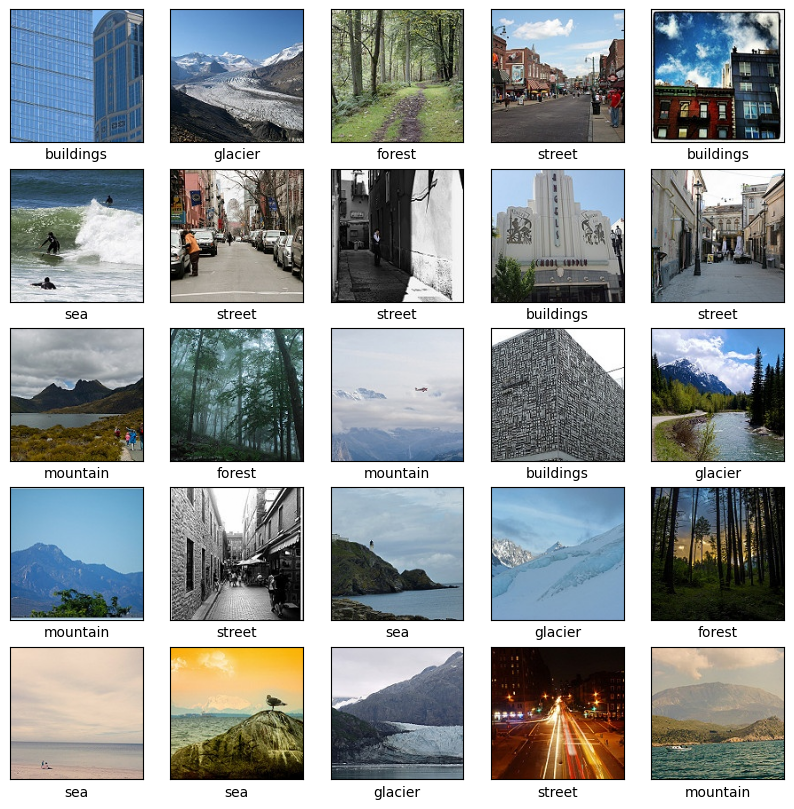

In [ ]:
label_to_index = {label: index for index, label in enumerate(class_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()


## **Use a Pretrained Model: VGG16:**

When working with deep learning for image processing, a common strategy is to start with a pretrained model. VGG16, known for its effectiveness in image classification, offers a great example of this approach.

## **Transfer Learning:**
Here, we use the pretrained weights of VGG16 as a base and adapt it to our specific needs by retraining the last few layers. This approach is particularly beneficial when our image categories differ from the original ImageNet classes. By fine-tuning the final layers, we can customize the model for our unique dataset with minimal additional training.



In [ ]:
# Import the VGG16 model from TensorFlow's Keras applications module.
# VGG16 is a deep convolutional neural network architecture known for its performance on the ImageNet visual recognition challenge.
from tensorflow.keras.applications import VGG16

In [ ]:
# Load the VGG16 model pre-trained weights on ImageNet dataset.
# include_top=False omits the fully connected layers at the top of the network, making it suitable for feature extraction.
# input_shape=(128, 128, 3) sets the shape of the input images the network expects. Here, it's 128x128 pixels with 3 color channels (RGB).
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Iterate through each layer in the base model.
for layer in VGG_model.layers:
    # Set the layer's trainable attribute to False.
    # This action freezes the weights and biases of the layer during training, meaning they won't be updated.
    # Freezing the pre-trained layers is important in transfer learning because we want to retain the knowledge the model has already learned from the ImageNet dataset.
    layer.trainable = False
    #layer.trainable = True

# It can used un freezes layers as well




In [ ]:
# Iterate through each layer in the base model.
#for layer in VGG_model.layers[-3:]:

#layer.trainable = True:

In [ ]:
#!pip install visualkeras

In [ ]:
import visualkeras

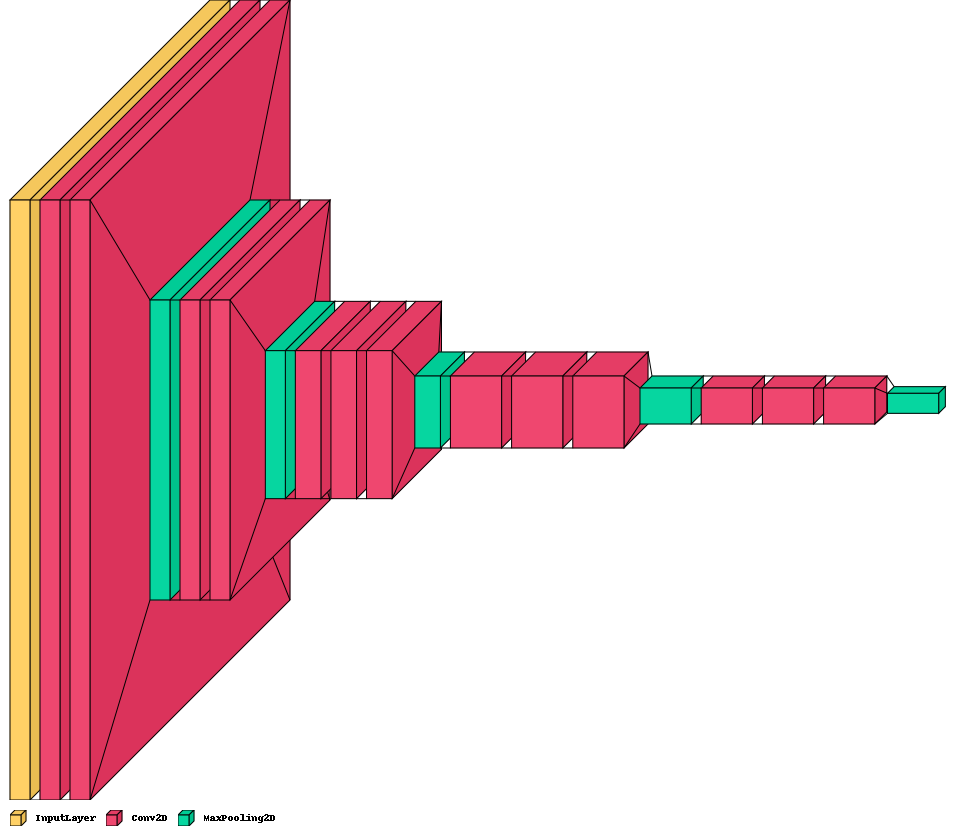

In [ ]:
# Let's visualize the model
visualkeras.layered_view(VGG_model,legend=True)

In [ ]:
from tensorflow.keras.utils import plot_model

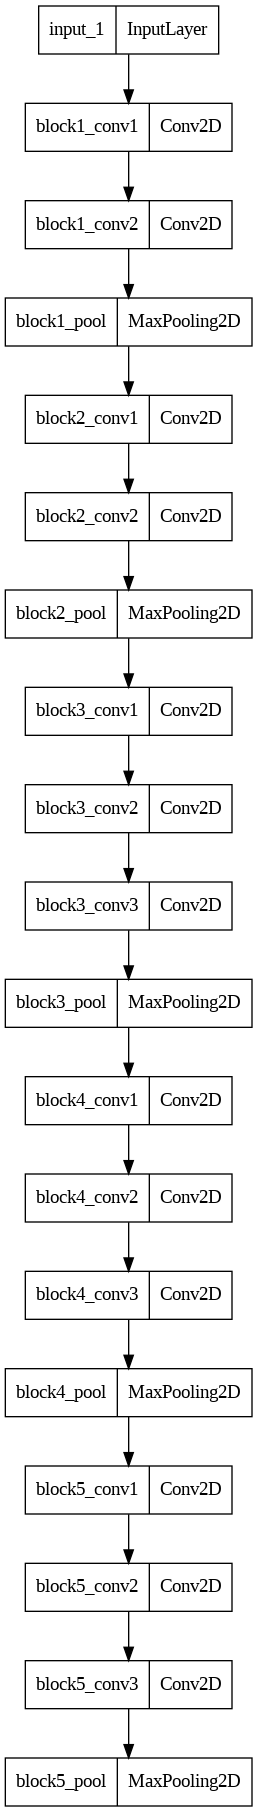

In [ ]:
plot_model(VGG_model)

In [ ]:
# `num_classes` will hold the total number of classes.

num_classes = len(class_names)

# Initialize a Sequential model.
model = models.Sequential()

# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
model.add(VGG_model)

# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) # Add a Dense (fully connected) layer to interpret the features extracted by VGG16.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
model.add(layers.Dense(num_classes, activation='softmax'))

Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded , epochs=10,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/10
439/439 [==============================] - 49s 95ms/step - loss: 0.5468 - accuracy: 0.7982 - val_loss: 0.3731 - val_accuracy: 0.8567
Epoch 2/10
439/439 [==============================] - 37s 84ms/step - loss: 0.3963 - accuracy: 0.8588 - val_loss: 0.3487 - val_accuracy: 0.8710
Epoch 3/10
439/439 [==============================] - 36s 82ms/step - loss: 0.3455 - accuracy: 0.8722 - val_loss: 0.3368 - val_accuracy: 0.8753
Epoch 4/10
439/439 [==============================] - 37s 84ms/step - loss: 0.3264 - accuracy: 0.8789 - val_loss: 0.3221 - val_accuracy: 0.8783
Epoch 5/10
439/439 [==============================] - 36s 83ms/step - loss: 0.2948 - accuracy: 0.8930 - val_loss: 0.3212 - val_accuracy: 0.8797
Epoch 6/10
439/439 [==============================] - 37s 83ms/step - loss: 0.2703 - accuracy: 0.8985 - val_loss: 0.3586 - val_accuracy: 0.8693
Epoch 7/10
439/439 [==============================] - 36s 83ms/step - loss: 0.2490 - accuracy: 0.9057 - val_loss: 0.3266 - val_accuracy:

### Evaluate the model

94/94 - 1s - loss: 0.8914 - accuracy: 0.7593 - 920ms/epoch - 10ms/step


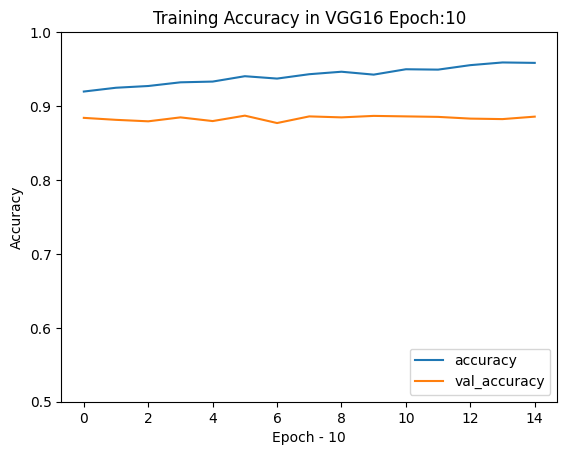

In [ ]:
# Plot Accuracy
#plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch - 10')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.title('Training Accuracy in VGG16 Epoch:10')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(test_acc)

0.8776666522026062


94/94 [==============================] - 7s 69ms/step


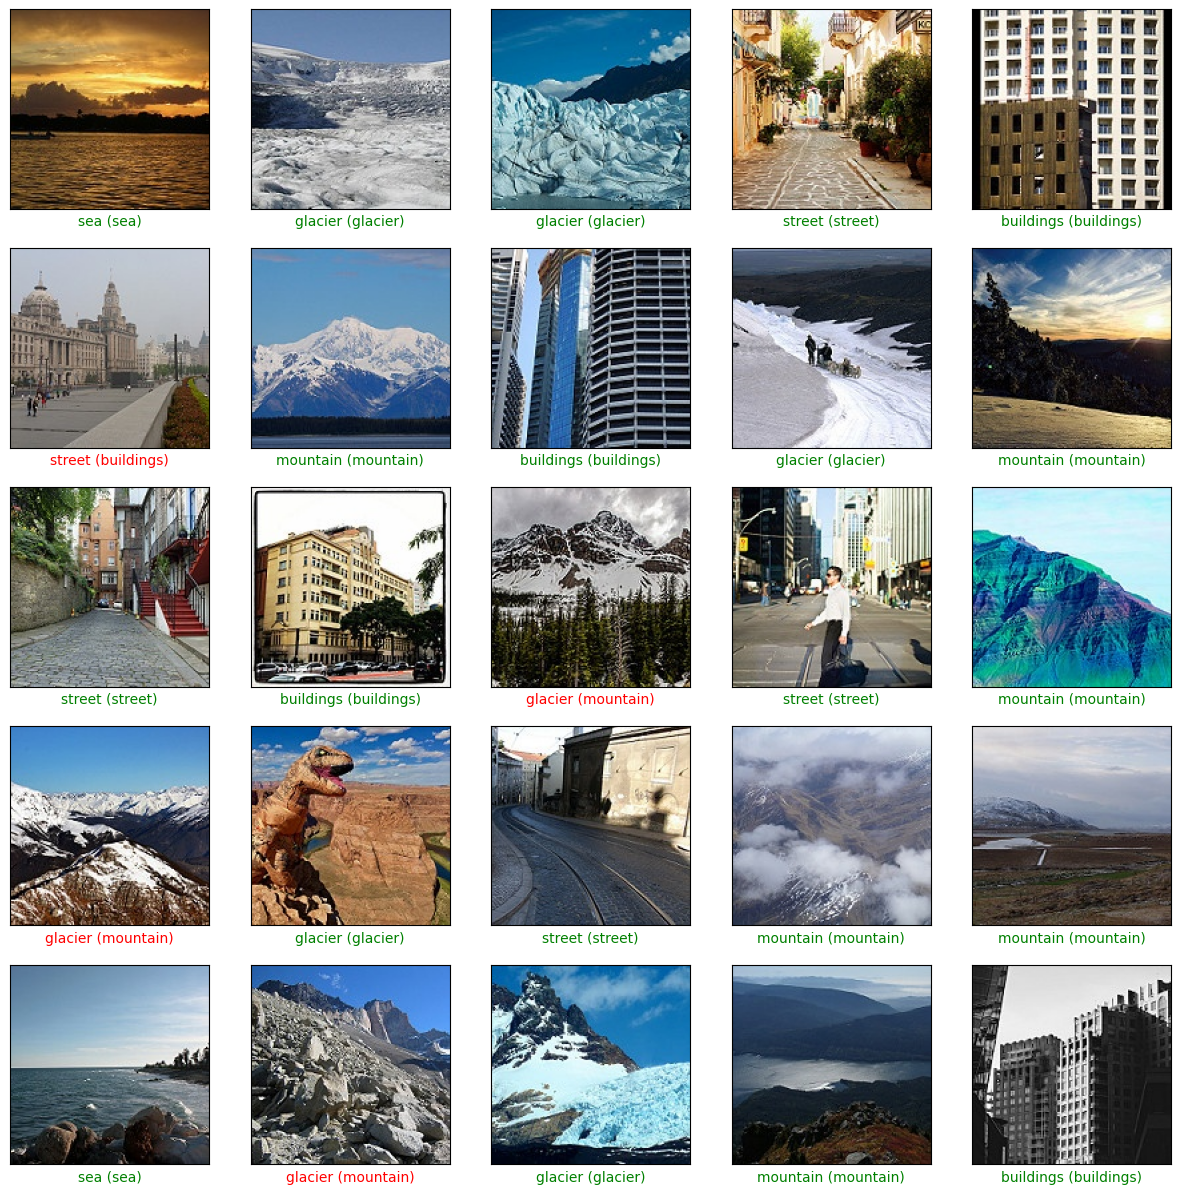

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()


In [ ]:
test_labels

array(['forest', 'forest', 'forest', ..., 'sea', 'sea', 'sea'],
      dtype='<U9')

In [ ]:
# Convert numerical labels back to class names
# Convert numerical labels back to class names
predicted_labels = [index_to_label[index] for index in predicted_labels]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sns

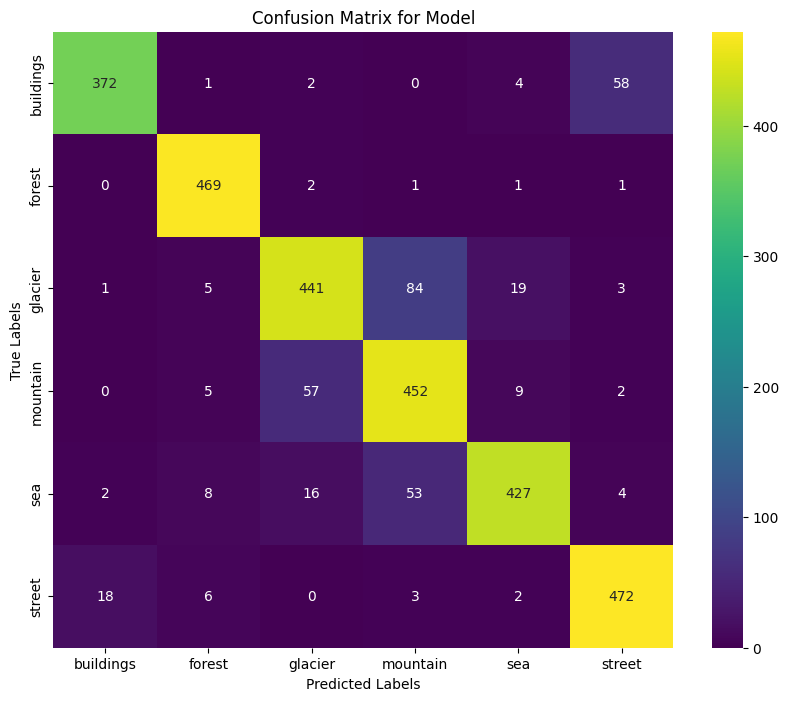

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Try the same model with epochs=15

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded , epochs=15,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/15
439/439 [==============================] - 39s 87ms/step - loss: 0.2147 - accuracy: 0.9196 - val_loss: 0.3681 - val_accuracy: 0.8840
Epoch 2/15
439/439 [==============================] - 36s 82ms/step - loss: 0.1972 - accuracy: 0.9248 - val_loss: 0.3833 - val_accuracy: 0.8813
Epoch 3/15
439/439 [==============================] - 37s 84ms/step - loss: 0.1925 - accuracy: 0.9271 - val_loss: 0.3778 - val_accuracy: 0.8793
Epoch 4/15
439/439 [==============================] - 36s 83ms/step - loss: 0.1734 - accuracy: 0.9321 - val_loss: 0.3952 - val_accuracy: 0.8847
Epoch 5/15
439/439 [==============================] - 37s 83ms/step - loss: 0.1737 - accuracy: 0.9331 - val_loss: 0.3819 - val_accuracy: 0.8797
Epoch 6/15
439/439 [==============================] - 37s 83ms/step - loss: 0.1540 - accuracy: 0.9404 - val_loss: 0.4083 - val_accuracy: 0.8870
Epoch 7/15
439/439 [==============================] - 37s 83ms/step - loss: 0.1634 - accuracy: 0.9372 - val_loss: 0.4195 - val_accuracy:

94/94 - 6s - loss: 0.5213 - accuracy: 0.8857 - 6s/epoch - 66ms/step


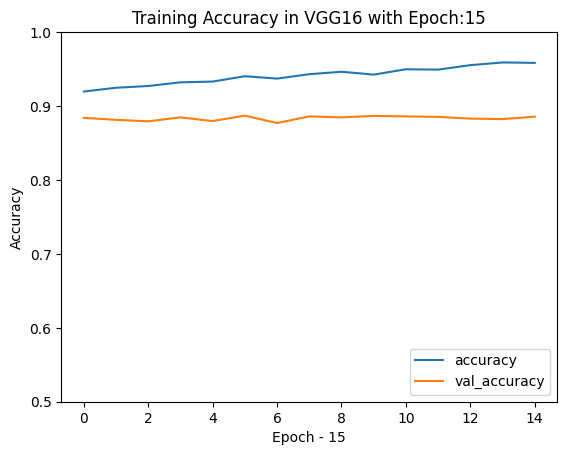

In [ ]:
# Plot Accuracy
#plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch - 15')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.title('Training Accuracy in VGG16 with Epoch:15')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(test_acc)

0.8856666684150696


94/94 [==============================] - 6s 67ms/step


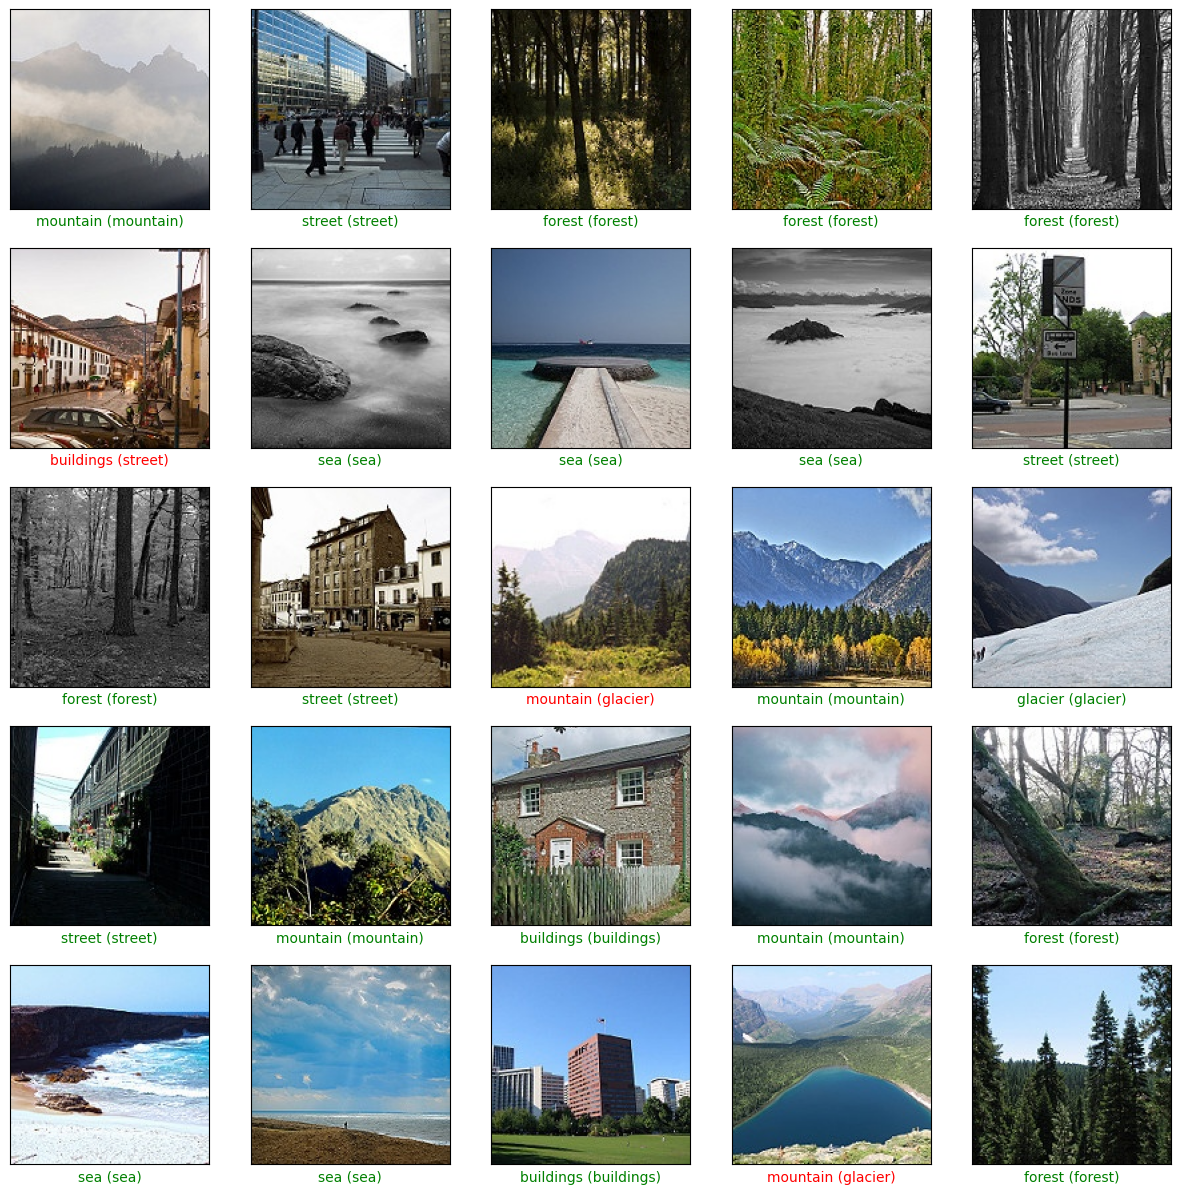

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()

# Training a model from scratch for the same task.

In [ ]:
# Core TensorFlow library for machine learning and neural network models.
import tensorflow as tf

# Visualization library for displaying the architecture of neural networks.
import visualkeras

# Pandas for data manipulation and analysis.
import pandas as pd

# Seaborn for statistical data visualization.
import seaborn as sns

# Matplotlib for plotting, e.g., displaying images and graphs.
import matplotlib.pyplot as plt

# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np

# Utilities for preprocessing images and decoding predictions.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# OS module for operating system interactions, such as file path management.
import os

# PIL (Python Imaging Library) for image processing tasks.
import PIL

# Importing components from Keras for building and training models.
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# VGG16 model from Keras applications for deep learning models pre-trained on ImageNet dataset.
from tensorflow.keras.applications import VGG16

# Utilities for plotting the architecture of neural networks.
from keras.utils import plot_model

# Scikit-learn for various machine learning tasks, such as evaluation metrics.
from sklearn.metrics import confusion_matrix

In [ ]:
# Create a Sequential model object to stack layers sequentially.
model = models.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu", input_shape=train_images[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 35, 35, 64)       

In [ ]:
model.compile(optimizer="adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early = EarlyStopping(patience=15, restore_best_weights=True)

In [ ]:
history_cnn = model.fit(train_images, train_labels_encoded, epochs=15,validation_data=(test_images, test_labels_encoded), callbacks=[early])

Epoch 1/15
439/439 [==============================] - 21s 48ms/step - loss: 0.1288 - accuracy: 0.9553 - val_loss: 1.2373 - val_accuracy: 0.7283
Epoch 2/15
439/439 [==============================] - 20s 46ms/step - loss: 0.1338 - accuracy: 0.9528 - val_loss: 1.3460 - val_accuracy: 0.7167
Epoch 3/15
439/439 [==============================] - 20s 45ms/step - loss: 0.1202 - accuracy: 0.9614 - val_loss: 1.1295 - val_accuracy: 0.7443
Epoch 4/15
439/439 [==============================] - 20s 45ms/step - loss: 0.1025 - accuracy: 0.9661 - val_loss: 1.0784 - val_accuracy: 0.7693
Epoch 5/15
439/439 [==============================] - 20s 46ms/step - loss: 0.0987 - accuracy: 0.9683 - val_loss: 0.9802 - val_accuracy: 0.7870
Epoch 6/15
439/439 [==============================] - 20s 45ms/step - loss: 0.0857 - accuracy: 0.9728 - val_loss: 1.6017 - val_accuracy: 0.7710
Epoch 7/15
439/439 [==============================] - 20s 46ms/step - loss: 0.0811 - accuracy: 0.9741 - val_loss: 1.1509 - val_accuracy:

94/94 - 1s - loss: 0.9802 - accuracy: 0.7870 - 910ms/epoch - 10ms/step


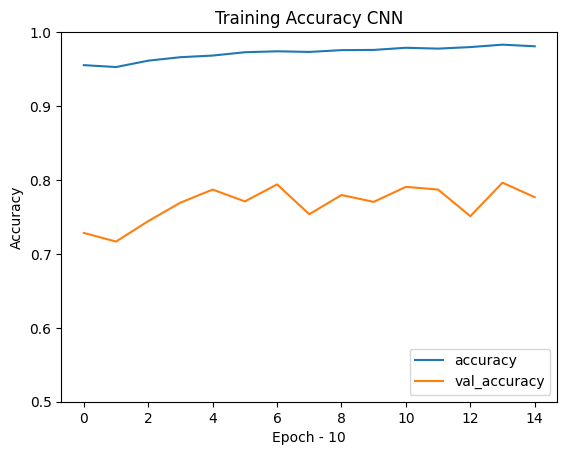

In [ ]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch - 10')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training Accuracy CNN')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(test_acc)

0.7870000004768372


94/94 [==============================] - 1s 9ms/step


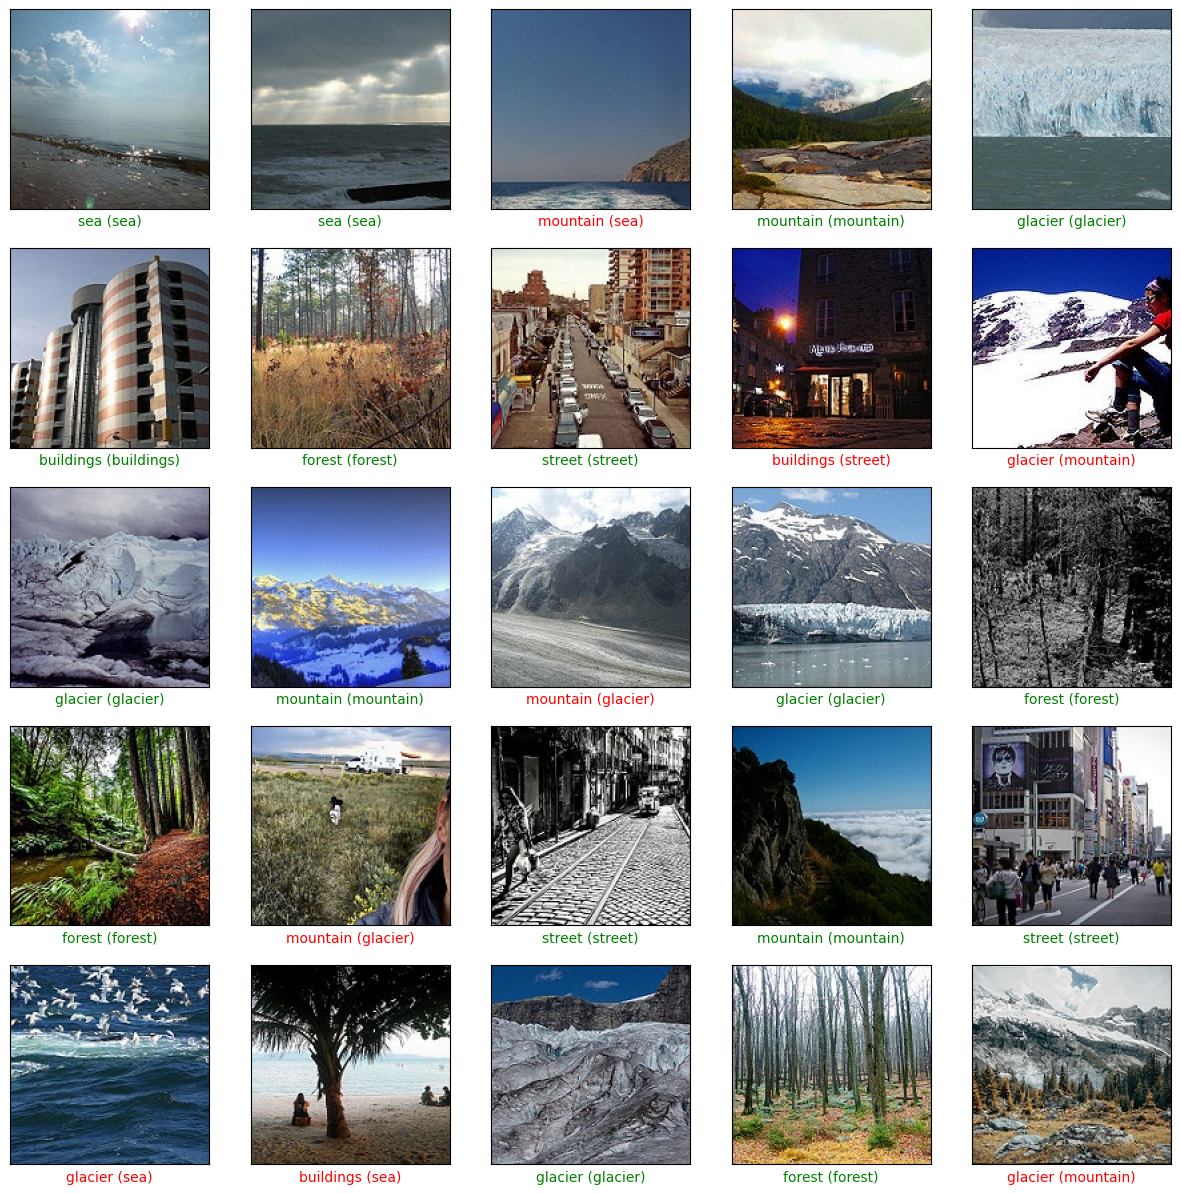

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()


In [ ]:
# Convert numerical labels back to class names
# Convert numerical labels back to class names
predicted_labels = [index_to_label[index] for index in predicted_labels]

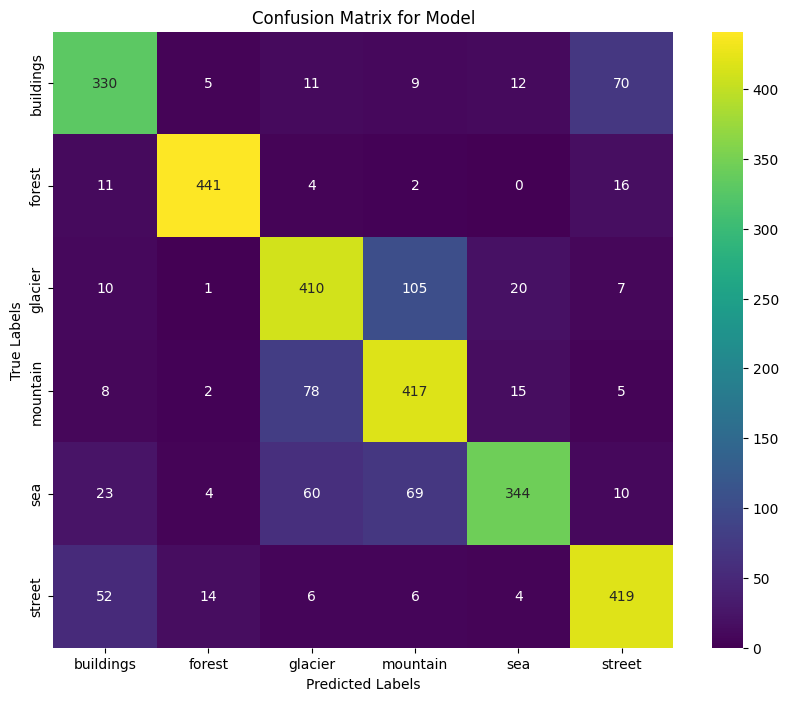

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Training Accuracy Comparison

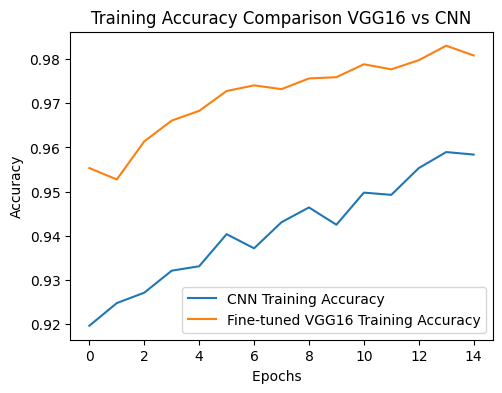

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Fine-tuned VGG16 Training Accuracy')
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.xlabel('Epochs  ')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison VGG16 vs CNN')
plt.legend()